Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
Image('notMNIST_large/A/a2VhZ2FuLnR0Zg==.png')

In [5]:
Image('notMNIST_large/B/a2VhZ2FuLnR0Zg==.png')

In [6]:
Image('notMNIST_large/C/a2VhZ2FuLnR0Zg==.png')

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [8]:
def show_images(images, nrows, ncols):
    plt.figure()
    n = min(nrows * ncols, len(images))
    for i in xrange(n):
        image = images[i]
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(image)

In [9]:
def random_sample_dataset(dataset, n):
    n = min(n, len(dataset))
    return [dataset[np.random.randint(len(dataset))] for i in xrange(n)]

def random_show_dataset(dataset):
    sample_images = random_sample_dataset(dataset, 5)
    show_images(sample_images, 1, 5)

In [10]:
def random_show_data(datasets):
    i = np.random.randint(len(datasets))
    dataset = pickle.load(open(datasets[i], 'rb'))
    random_show_dataset(dataset)

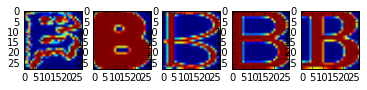

In [11]:
random_show_data(train_datasets)

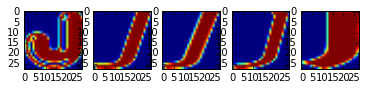

In [12]:
random_show_data(test_datasets)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [13]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [14]:
def summarize_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

print("valid_labels:", summarize_labels(valid_labels))
print("train_labels:", summarize_labels(train_labels))
print("test_labels:", summarize_labels(test_labels))

valid_labels: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
train_labels: {0: 20000, 1: 20000, 2: 20000, 3: 20000, 4: 20000, 5: 20000, 6: 20000, 7: 20000, 8: 20000, 9: 20000}
test_labels: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [15]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [16]:
def random_show_label_and_data(dataset, labels):
    i = np.random.randint(len(labels))
    print("labels[%d]=%d" % (i, labels[i]))
    plt.imshow(dataset[i])

labels[7382]=8


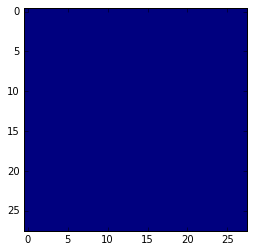

In [17]:
random_show_label_and_data(valid_dataset, valid_labels)

labels[24311]=1


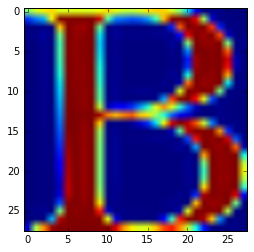

In [18]:
random_show_label_and_data(train_dataset, train_labels)

labels[1347]=0


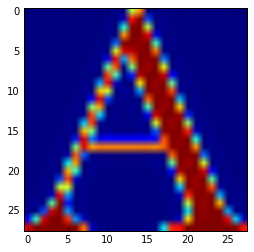

In [19]:
random_show_label_and_data(test_dataset, test_labels)

Finally, let's save the data for later reuse:

In [20]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [21]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [22]:
""" This doesn't work because hash key conflict too seriously """

def ndarray_to_tuple(a):
    return tuple(a.ravel())

def dataset_to_hash(dataset):
    h = {}
    for i, e in enumerate(dataset):
        t = ndarray_to_tuple(e)
        if t not in h:
            h[t] = []
        h[t].append(i)
    return h

def search_overlap(dataset1, dataset2):
    hash1 = dataset_to_hash(dataset1)
    set1 = set(hash1)

    hash2 = dataset_to_hash(dataset2)
    set2 = set(hash2)

    intersection = set1.intersection(set2)
    overlap_indice = []
    for k in intersection:
        #print(hash1[k], hash2[k])
        #return
        overlap_indice.extend(hash2[k])
    return overlap_indice

valid_overlap = search_overlap(train_dataset[:1000], valid_dataset[:1000])
print(valid_overlap)

[66, 75, 521, 757, 810, 868]


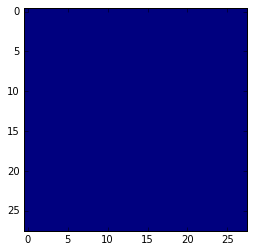

In [23]:
#plt.imshow(train_dataset[95260])
#plt.imshow(valid_dataset[9867])
plt.imshow(valid_dataset[868])

In [24]:
# return overlaps between dataset1 and dataset2
def search_overlap(dataset1, labels1, dataset2, labels2):
    overlap = {}
    for i1, d1 in enumerate(dataset1):
        for i2, d2 in enumerate(dataset2):
            if labels1[i1] != labels2[i2]:
                continue
            if not np.array_equal(d1, d2):
                continue
            if i2 not in overlap:
                overlap[i2] = set()
            overlap[i2].add(i1)
    return overlap

In [25]:
%time valid_overlap = search_overlap(train_dataset, train_labels, valid_dataset, valid_labels)
len(valid_overlap)

CPU times: user 23min 24s, sys: 24 ms, total: 23min 24s
Wall time: 23min 24s


1101

In [26]:
%time test_overlap = search_overlap(train_dataset, train_labels, test_dataset, test_labels)
len(test_overlap)

CPU times: user 22min 54s, sys: 92 ms, total: 22min 54s
Wall time: 22min 54s


1240

In [35]:
# return overlaps between dataset1 and dataset2 (nearly duplicate)
def search_overlap_nearly_dup(dataset1, labels1, dataset2, labels2):
    overlap = {}
    for i1, d1 in enumerate(dataset1):
        for i2, d2 in enumerate(dataset2):
            if labels1[i1] != labels2[i2]:
                continue
            diff = d1 - d2
            norm = np.sum(np.abs(diff))
            if norm > 10:
                continue
            if i2 not in overlap:
                overlap[i2] = set()
            overlap[i2].add(i1)
    return overlap

In [36]:
%time valid_overlap_nearly_dup = search_overlap_nearly_dup(train_dataset, train_labels, valid_dataset, valid_labels)
len(valid_overlap_nearly_dup)

CPU times: user 32min 35s, sys: 184 ms, total: 32min 35s
Wall time: 32min 35s


2207

In [37]:
%time test_overlap_nearly_dup = search_overlap_nearly_dup(train_dataset, train_labels, test_dataset, test_labels)
len(test_overlap_nearly_dup)

CPU times: user 32min 43s, sys: 232 ms, total: 32min 43s
Wall time: 32min 44s


2518

In [29]:
def random_pick_keys(h, n):
    keys = h.keys()
    n = min(n, len(keys))
    return [keys[np.random.randint(len(keys))] for i in xrange(n)]

def random_show_overlap(overlap, dataset1, dataset2):
    i2s = random_pick_keys(overlap, 3)
    print(i2s)
    for i2 in i2s:
        i1s = overlap[i2]
        images = [dataset1[i1] for i1 in i1s]
        sample_images = random_sample_dataset(images, 5)
        images_to_show = [dataset2[i2]] + sample_images
        show_images(images_to_show, 1, 6)

[4204, 990, 1223]


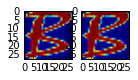

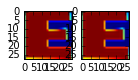

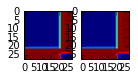

In [30]:
random_show_overlap(valid_overlap, train_dataset, valid_dataset)

[6803, 8390, 5741]


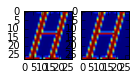

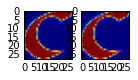

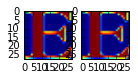

In [33]:
random_show_overlap(test_overlap, train_dataset, test_dataset)

[4454, 8499, 8493]


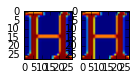

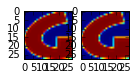

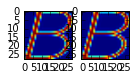

In [38]:
random_show_overlap(valid_overlap_nearly_dup, train_dataset, valid_dataset)

[4425, 3123, 1952]


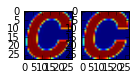

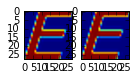

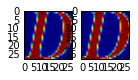

In [39]:
random_show_overlap(test_overlap_nearly_dup, train_dataset, test_dataset)

In [31]:
def save_datasets(pickle_file, train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels):
    try:
      f = open(pickle_file, 'wb')
      save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise

In [40]:
def exclude_overlap(overlap, dataset, labels):
    indices = overlap.keys()
    excluded_dataset = np.delete(dataset, indices, axis=0)
    excluded_labels = np.delete(labels, indices, axis=0)
    return excluded_dataset, excluded_labels

def save_excluded_datasets():
    excluded_valid_dataset, excluded_valid_labels = exclude_overlap(valid_overlap, valid_dataset, valid_labels)
    excluded_test_dataset, excluded_test_labels = exclude_overlap(test_overlap, test_dataset, test_labels)
    save_datasets('notMNIST-exclude-dup.pickle', train_dataset, train_labels, excluded_valid_dataset, excluded_valid_labels, excluded_test_dataset, excluded_test_labels)

def save_excluded_datasets_nearly_dup():
    excluded_valid_dataset, excluded_valid_labels = exclude_overlap(valid_overlap_nearly_dup, valid_dataset, valid_labels)
    excluded_test_dataset, excluded_test_labels = exclude_overlap(test_overlap_nearly_dup, test_dataset, test_labels)
    save_datasets('notMNIST-exclude-nearly-dup.pickle', train_dataset, train_labels, excluded_valid_dataset, excluded_valid_labels, excluded_test_dataset, excluded_test_labels)

save_excluded_datasets()
save_excluded_datasets_nearly_dup()

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---